In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install catboost
!pip install optuna
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 14.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.3/365.3 KB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.6/210.6 KB 22.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 KB 9.3 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 575.9/575.9 KB 9.8 MB/s eta 0:00:00


In [3]:
import numpy as np
import pandas as pd

import sklearn
import sklearn.metrics
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, auc, precision_score, recall_score, f1_score, classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, matthews_corrcoef
from sklearn.model_selection import train_test_split
from sklearn.calibration import calibration_curve
from math import sqrt
from scipy import stats as st
from random import randrange
from matplotlib import pyplot

import xgboost as xgb
import lightgbm as lgb
import catboost as cb
from sklearn.ensemble import RandomForestClassifier

import optuna
from optuna.samplers import TPESampler

import shap

# Preparing Data

In [4]:
#Open csv file.

data = pd.read_csv('/content/drive/MyDrive/NTDB-Epidural/final_data.csv', index_col = 0)

In [5]:
data['Discharge Disposition'].value_counts(normalize=False, dropna=False)

Discharged to home or self-care (routine discharge)                                                 3153
NaN                                                                                                  354
Discharged/Transferred to inpatient rehab or designated unit                                         326
Discharged/Transferred to home under care of organized home health service                           272
Discharged/Transferred to Skilled Nursing Facility (SNF)                                             233
Left against medical advice or discontinued care                                                     172
Deceased/Expired                                                                                      83
Discharged/Transferred to court/law enforcement.                                                      47
Discharged/Transferred to a short-term general hospital for inpatient care                            39
Discharged/Transferred to Long Term Care Hospital (LTCH

In [6]:
#Drop patients with unknown outcome of interest.

before = data.shape[0]
data = data[data['Discharge Disposition'].notna()]
after = data.shape[0]

excluded = before - after
print('Number of patients before exclusion: ', before)
print('Number of patients after exclusion: ', after)
print('Number of patients excluded with this criteria: ', excluded)

Number of patients before exclusion:  4790
Number of patients after exclusion:  4436
Number of patients excluded with this criteria:  354


In [7]:
#Define outcome of interest.

data.loc[data['Discharge Disposition'] == 'Discharged to home or self-care (routine discharge)', 'OUTCOME'] = 0
data.loc[data['Discharge Disposition'] == 'Discharged/Transferred to inpatient rehab or designated unit', 'OUTCOME'] = 1
data.loc[data['Discharge Disposition'] == 'Discharged/Transferred to home under care of organized home health service', 'OUTCOME'] = 1
data.loc[data['Discharge Disposition'] == 'Discharged/Transferred to Skilled Nursing Facility (SNF)', 'OUTCOME'] = 1
data.loc[data['Discharge Disposition'] == 'Discharged/Transferred to Long Term Care Hospital (LTCH)', 'OUTCOME'] = 1
data.loc[data['Discharge Disposition'] == 'Discharged/Transferred to a short-term general hospital for inpatient care', 'OUTCOME'] = 1
data.loc[data['Discharge Disposition'] == 'Discharged/Transferred to an Intermediate Care Facility (ICF)', 'OUTCOME'] = 1
data = data[data['OUTCOME'].notna()]

data['OUTCOME'].value_counts(normalize=False, dropna=False)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


0.0    3153
1.0     909
Name: OUTCOME, dtype: int64

In [8]:
#Define predictor variables (x) and outcome of interest (y).

outcomes = ['Total Length of Stay', 'Discharge Disposition', 'Hospital Complication - Cardiac Arrest with CPR', 'Hospital Complication - Catheter-Associated Urinary Tract Infection (CAUTI)', 'Hospital Complication - Central Line-Associated Bloodstream Infection (CLABSI)', 'Hospital Complication - Catheter-Related Blood Stream Infection', 'Hospital Complication - Deep Surgical Site Infection', 'Hospital Complication - Delirium', 'Hospital Complication - Alcohol Withdrawal Syndrome', 'Hospital Complication - Deep Vein Thrombosis (DVT)', 'Hospital Complication - Pulmonary Embolism', 'Hospital Complication - Extremity Compartment Syndrome', 'Hospital Complication - Graft or Prosthesis or Flap Failure', 'Hospital Complication - Unplanned Intubation', 'Hospital Complication - Acute Kidney Injury', 'Hospital Complication - Myocardial Infarction', 'Hospital Complication - Organ or Space Surgical Site Infection', 'Hospital Complication - Osteomyelitis', 'Hospital Complication - Pneumonia', 'Hospital Complication - Pressure or Decubitis Ulcer', 'Hospital Complication - Acute Respiratory Distress Syndrome (ARDS)', 'Hospital Complication - Unplanned Return to the OR', 'Hospital Complication - Severe Sepsis', 'Hospital Complication - Stroke  or  CVA', 'Hospital Complication - Superficial Surgical Site Infection', 'Hospital Complication - Unplanned Admission to the ICU', 'Hospital Complication - Urinary Tract Infection', 'Hospital Complication - Ventilator-Associated Pneumonia (VAP)', 'Total ICU Length of Stay', 'OUTCOME']

x = data.drop(outcomes, axis = 1)
y = data['OUTCOME']

In [9]:
#Check data shapes.

print(y.shape)
print(x.shape)

(4062,)
(4062, 249)


In [10]:
#Split data into initial train set and test set in 80:20 ratio.

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 0)
  
#Describe initial train set and test set.

print("Number patients x_train dataset: ", x_train.shape[0])
print("Number patients y_train dataset: ", y_train.shape[0])
print("Number patients x_test dataset: ", x_test.shape[0])
print("Number patients y_test dataset: ", y_test.shape[0])

Number patients x_train dataset:  3249
Number patients y_train dataset:  3249
Number patients x_test dataset:  813
Number patients y_test dataset:  813


In [11]:
#Split initial train set into final train set and validation set in 75:25 ratio.

train_x, valid_x, train_y, valid_y = train_test_split(x_train, y_train, test_size = 0.25, random_state = 0)
  
#Describe train and validation sets.

print("Number patients train_x dataset: ", train_x.shape[0])
print("Number patients train_y dataset: ", train_y.shape[0])
print("Number patients valid_x dataset: ", valid_x.shape[0])
print("Number patients valid_y dataset: ", valid_y.shape[0])

Number patients train_x dataset:  2436
Number patients train_y dataset:  2436
Number patients valid_x dataset:  813
Number patients valid_y dataset:  813


In [12]:
#Describe outcome of interest before resampling.

print("Before resampling, counts of label '1': {}".format(sum(train_y == 1)))
print("Before resampling, counts of label '0': {} \n".format(sum(train_y == 0)))

Before resampling, counts of label '1': 544
Before resampling, counts of label '0': 1892 



In [13]:
#Apply SMOTE.

from imblearn.over_sampling import SMOTE

resampler = SMOTE(random_state = 0)
train_x, train_y = resampler.fit_resample(train_x, train_y)

In [14]:
#Describe outcome of interest after resampling.

print("After resampling, counts of label '1': {}".format(sum(train_y == 1)))
print("After resampling, counts of label '0': {} \n".format(sum(train_y == 0)))

After resampling, counts of label '1': 1892
After resampling, counts of label '0': 1892 



In [15]:
def roc_auc_ci(y_test, y_probs, positive=1):
    AUC = roc_auc_score(y_test, y_probs)
    N1 = sum(y_test == positive)
    N2 = sum(y_test != positive)
    Q1 = AUC / (2 - AUC)
    Q2 = 2*AUC**2 / (1 + AUC)
    SE_AUC = sqrt((AUC*(1 - AUC) + (N1 - 1)*(Q1 - AUC**2) + (N2 - 1)*(Q2 - AUC**2)) / (N1*N2))
    lower = AUC - 1.96*SE_AUC
    upper = AUC + 1.96*SE_AUC
    if lower < 0:
        lower = 0
    if upper > 1:
        upper = 1
    return (lower, upper)

# XGBoost

In [16]:
#Hyperparameter tuning for XGBoost.

def objective(trial):

    dtrain = xgb.DMatrix(train_x, label=train_y)
    dvalid = xgb.DMatrix(valid_x, label=valid_y)

    param = {
        "seed": 31,
        "verbosity": 0,
        "objective":  trial.suggest_categorical("objective", ["binary:logistic"]),
        "eval_metric": "auc",
        "booster": trial.suggest_categorical("booster", ["gbtree"]),
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        "max_depth" : trial.suggest_int("max_depth", 1, 9),
        "eta" : trial.suggest_float("eta", 1e-8, 1.0, log=True),
        "gamma" : trial.suggest_float("gamma", 1e-8, 1.0, log=True),
        "grow_policy" : trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])
    }


    # Add a callback for pruning.
    pruning_callback = optuna.integration.XGBoostPruningCallback(trial, "validation-auc")
    
    bst = xgb.train(param, dtrain, evals=[(dvalid, "validation")], callbacks=[pruning_callback])
    preds = bst.predict(dvalid)
    pred_labels = np.rint(preds)
    auc = sklearn.metrics.roc_auc_score(valid_y, pred_labels)

    return auc


if __name__ == "__main__":
    study = optuna.create_study(
        pruner=optuna.pruners.MedianPruner(n_warmup_steps=5), direction="maximize", sampler = TPESampler(seed=31)
    )
    study.optimize(objective, n_trials=100)
    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))
        
    xgb_params = {}
    
    for key, value in trial.params.items():
        xgb_params[key] = value

[I 2023-01-23 04:01:06,467] A new study created in memory with name: no-name-4e34e1bb-79ea-49ef-8673-38ffafb35766


[0]	validation-auc:0.752724
[1]	validation-auc:0.77031
[2]	validation-auc:0.779115
[3]	validation-auc:0.781937
[4]	validation-auc:0.784107
[5]	validation-auc:0.78197
[6]	validation-auc:0.774454
[7]	validation-auc:0.775946
[8]	validation-auc:0.776444
[9]	validation-auc:0.780082


[I 2023-01-23 04:01:07,227] Trial 0 finished with value: 0.676325448613377 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 1.9428110874325094e-06, 'alpha': 0.4622155288125666, 'max_depth': 7, 'eta': 0.7851633597929335, 'gamma': 4.627257790053709e-07, 'grow_policy': 'lossguide'}. Best is trial 0 with value: 0.676325448613377.


[0]	validation-auc:0.502659
[1]	validation-auc:0.687708
[2]	validation-auc:0.731762
[3]	validation-auc:0.753397
[4]	validation-auc:0.746122
[5]	validation-auc:0.744657
[6]	validation-auc:0.740379
[7]	validation-auc:0.749621
[8]	validation-auc:0.761811
[9]	validation-auc:0.759539


[I 2023-01-23 04:01:07,840] Trial 1 finished with value: 0.6961990212071778 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 3.540855010579091e-08, 'alpha': 4.005546508605542e-08, 'max_depth': 5, 'eta': 5.190362998186933e-08, 'gamma': 1.1458984717217304e-05, 'grow_policy': 'depthwise'}. Best is trial 1 with value: 0.6961990212071778.


[0]	validation-auc:0.5
[1]	validation-auc:0.559608
[2]	validation-auc:0.668931
[3]	validation-auc:0.737561
[4]	validation-auc:0.731762
[5]	validation-auc:0.753181
[6]	validation-auc:0.759078
[7]	validation-auc:0.746122
[8]	validation-auc:0.74447
[9]	validation-auc:0.744657


[I 2023-01-23 04:01:08,282] Trial 2 finished with value: 0.6961990212071778 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 2.2472451918309905e-08, 'alpha': 3.5833391127860344e-07, 'max_depth': 5, 'eta': 3.166549087607022e-08, 'gamma': 2.4018078289549153e-06, 'grow_policy': 'depthwise'}. Best is trial 1 with value: 0.6961990212071778.


[0]	validation-auc:0.746101
[1]	validation-auc:0.744347
[2]	validation-auc:0.752643
[3]	validation-auc:0.752635
[4]	validation-auc:0.749299
[5]	validation-auc:0.748316
[6]	validation-auc:0.751113
[7]	validation-auc:0.749971
[8]	validation-auc:0.749025
[9]	validation-auc:0.749013


[I 2023-01-23 04:01:08,893] Trial 3 finished with value: 0.6803833605220229 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 1.3853144759016545e-06, 'alpha': 1.810306176116705e-05, 'max_depth': 8, 'eta': 0.00011313716853812925, 'gamma': 1.431538552328043e-06, 'grow_policy': 'lossguide'}. Best is trial 1 with value: 0.6961990212071778.


[0]	validation-auc:0.745759
[1]	validation-auc:0.743691
[2]	validation-auc:0.748271
[3]	validation-auc:0.747635
[4]	validation-auc:0.744205
[5]	validation-auc:0.744315
[6]	validation-auc:0.744319
[7]	validation-auc:0.747268
[8]	validation-auc:0.747753
[9]	validation-auc:0.744144


[I 2023-01-23 04:01:09,439] Trial 4 finished with value: 0.721305057096248 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 2.981512489677599e-07, 'alpha': 8.673160455297617e-07, 'max_depth': 7, 'eta': 1.1789142339699406e-05, 'gamma': 4.915182221710387e-05, 'grow_policy': 'depthwise'}. Best is trial 4 with value: 0.721305057096248.


[0]	validation-auc:0.5
[1]	validation-auc:0.721484
[2]	validation-auc:0.721484
[3]	validation-auc:0.721484
[4]	validation-auc:0.721484


[I 2023-01-23 04:01:09,840] Trial 5 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.759825
[1]	validation-auc:0.773136
[2]	validation-auc:0.782569
[3]	validation-auc:0.783006
[4]	validation-auc:0.785175
[5]	validation-auc:0.790991
[6]	validation-auc:0.791672
[7]	validation-auc:0.802145
[8]	validation-auc:0.804715
[9]	validation-auc:0.806342


[I 2023-01-23 04:01:10,789] Trial 6 finished with value: 0.7147267536704731 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.04528142691329445, 'alpha': 0.010014797160429703, 'max_depth': 5, 'eta': 0.08681503874329109, 'gamma': 1.7151544620195505e-06, 'grow_policy': 'lossguide'}. Best is trial 4 with value: 0.721305057096248.


[0]	validation-auc:0.5
[1]	validation-auc:0.5
[2]	validation-auc:0.5
[3]	validation-auc:0.5
[4]	validation-auc:0.498475


[I 2023-01-23 04:01:11,351] Trial 7 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.744025
[1]	validation-auc:0.743691
[2]	validation-auc:0.749417
[3]	validation-auc:0.747635
[4]	validation-auc:0.744205


[I 2023-01-23 04:01:12,156] Trial 8 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.764804
[1]	validation-auc:0.764804
[2]	validation-auc:0.764804
[3]	validation-auc:0.764804
[4]	validation-auc:0.764804
[5]	validation-auc:0.764804
[6]	validation-auc:0.764804
[7]	validation-auc:0.764804
[8]	validation-auc:0.764804
[9]	validation-auc:0.764804


[I 2023-01-23 04:01:14,014] Trial 9 finished with value: 0.6989641109298531 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.009931126321758296, 'alpha': 1.5117729868865979e-05, 'max_depth': 4, 'eta': 0.00026829123048597897, 'gamma': 5.2949738366436485e-05, 'grow_policy': 'depthwise'}. Best is trial 4 with value: 0.721305057096248.


[0]	validation-auc:0.728426
[1]	validation-auc:0.727414
[2]	validation-auc:0.734327
[3]	validation-auc:0.734967
[4]	validation-auc:0.733564


[I 2023-01-23 04:01:16,783] Trial 10 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.759951
[1]	validation-auc:0.764278
[2]	validation-auc:0.765237
[3]	validation-auc:0.768246
[4]	validation-auc:0.772382
[5]	validation-auc:0.774984
[6]	validation-auc:0.775946
[7]	validation-auc:0.776517
[8]	validation-auc:0.776378
[9]	validation-auc:0.777863


[I 2023-01-23 04:01:18,712] Trial 11 finished with value: 0.6979363784665579 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.5800874763958492, 'alpha': 0.001594892913610864, 'max_depth': 6, 'eta': 0.010657872856106384, 'gamma': 1.2024518784549119e-08, 'grow_policy': 'lossguide'}. Best is trial 4 with value: 0.721305057096248.


[0]	validation-auc:0.753038
[1]	validation-auc:0.753038
[2]	validation-auc:0.753038
[3]	validation-auc:0.753038
[4]	validation-auc:0.753038
[5]	validation-auc:0.764596
[6]	validation-auc:0.762537
[7]	validation-auc:0.762504
[8]	validation-auc:0.762602
[9]	validation-auc:0.762602


[I 2023-01-23 04:01:19,411] Trial 12 finished with value: 0.6889763458401306 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.48585861043331224, 'alpha': 0.004189485227815155, 'max_depth': 3, 'eta': 0.00468543805838847, 'gamma': 0.0003372544579383088, 'grow_policy': 'depthwise'}. Best is trial 4 with value: 0.721305057096248.


[0]	validation-auc:0.762728
[1]	validation-auc:0.788956
[2]	validation-auc:0.784547
[3]	validation-auc:0.782219
[4]	validation-auc:0.774666
[5]	validation-auc:0.772989
[6]	validation-auc:0.765616
[7]	validation-auc:0.770706
[8]	validation-auc:0.76168
[9]	validation-auc:0.761183


[I 2023-01-23 04:01:20,782] Trial 13 finished with value: 0.6880628058727569 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 6.937438860501692e-05, 'alpha': 0.037208586933264384, 'max_depth': 6, 'eta': 0.8516409744831562, 'gamma': 0.5697473004700789, 'grow_policy': 'lossguide'}. Best is trial 4 with value: 0.721305057096248.


[0]	validation-auc:0.728516
[1]	validation-auc:0.735493
[2]	validation-auc:0.752741
[3]	validation-auc:0.756778
[4]	validation-auc:0.755604


[I 2023-01-23 04:01:22,991] Trial 14 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.74564
[1]	validation-auc:0.743748
[2]	validation-auc:0.748601
[3]	validation-auc:0.748132
[4]	validation-auc:0.744445


[I 2023-01-23 04:01:24,640] Trial 15 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.764804
[1]	validation-auc:0.764804
[2]	validation-auc:0.764804
[3]	validation-auc:0.764804
[4]	validation-auc:0.764804
[5]	validation-auc:0.764804
[6]	validation-auc:0.764804
[7]	validation-auc:0.764804
[8]	validation-auc:0.764804
[9]	validation-auc:0.764804


[I 2023-01-23 04:01:26,013] Trial 16 finished with value: 0.6989641109298531 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 9.519702858567952e-06, 'alpha': 0.0006424960761276887, 'max_depth': 4, 'eta': 0.0006592745712542047, 'gamma': 4.971880958604258e-07, 'grow_policy': 'lossguide'}. Best is trial 4 with value: 0.721305057096248.


[0]	validation-auc:0.721484
[1]	validation-auc:0.721484
[2]	validation-auc:0.721484
[3]	validation-auc:0.721484
[4]	validation-auc:0.721484


[I 2023-01-23 04:01:26,689] Trial 17 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.760808
[1]	validation-auc:0.771913
[2]	validation-auc:0.775188
[3]	validation-auc:0.777043
[4]	validation-auc:0.786297
[5]	validation-auc:0.788185
[6]	validation-auc:0.789441
[7]	validation-auc:0.784963
[8]	validation-auc:0.787814
[9]	validation-auc:0.79146


[I 2023-01-23 04:01:28,039] Trial 18 finished with value: 0.6971207177814028 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 9.192862531041452e-06, 'alpha': 0.00011071455772808495, 'max_depth': 6, 'eta': 0.05431851017856415, 'gamma': 7.816829944306752e-05, 'grow_policy': 'depthwise'}. Best is trial 4 with value: 0.721305057096248.


[0]	validation-auc:0.739005
[1]	validation-auc:0.738157
[2]	validation-auc:0.7373
[3]	validation-auc:0.737512
[4]	validation-auc:0.737504


[I 2023-01-23 04:01:29,187] Trial 19 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.753038
[1]	validation-auc:0.753038
[2]	validation-auc:0.753038
[3]	validation-auc:0.753038
[4]	validation-auc:0.753038


[I 2023-01-23 04:01:29,924] Trial 20 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.764804
[1]	validation-auc:0.764804
[2]	validation-auc:0.764804
[3]	validation-auc:0.764804
[4]	validation-auc:0.764804
[5]	validation-auc:0.764804
[6]	validation-auc:0.764804
[7]	validation-auc:0.764804
[8]	validation-auc:0.764804
[9]	validation-auc:0.764804


[I 2023-01-23 04:01:30,883] Trial 21 finished with value: 0.6989641109298531 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.02125596003920111, 'alpha': 1.615325788723917e-05, 'max_depth': 4, 'eta': 0.00014452672170874343, 'gamma': 5.150755138650244e-05, 'grow_policy': 'depthwise'}. Best is trial 4 with value: 0.721305057096248.


[0]	validation-auc:0.764804
[1]	validation-auc:0.774409
[2]	validation-auc:0.777679
[3]	validation-auc:0.781554
[4]	validation-auc:0.780856
[5]	validation-auc:0.782953
[6]	validation-auc:0.797582
[7]	validation-auc:0.79821
[8]	validation-auc:0.801366
[9]	validation-auc:0.805971


[I 2023-01-23 04:01:32,138] Trial 22 finished with value: 0.726358075040783 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.002673059243175026, 'alpha': 2.5972441880229166e-05, 'max_depth': 4, 'eta': 0.0670723816227293, 'gamma': 3.8932893421594024e-06, 'grow_policy': 'depthwise'}. Best is trial 22 with value: 0.726358075040783.


[0]	validation-auc:0.758764
[1]	validation-auc:0.763087
[2]	validation-auc:0.763087
[3]	validation-auc:0.763087
[4]	validation-auc:0.763087
[5]	validation-auc:0.765808
[6]	validation-auc:0.779861
[7]	validation-auc:0.779568
[8]	validation-auc:0.779943
[9]	validation-auc:0.78126


[I 2023-01-23 04:01:33,883] Trial 23 finished with value: 0.7099510603588908 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.0011609522446647481, 'alpha': 0.0006756132954786335, 'max_depth': 2, 'eta': 0.042971514112100796, 'gamma': 4.277831960568568e-06, 'grow_policy': 'depthwise'}. Best is trial 22 with value: 0.726358075040783.


[0]	validation-auc:0.759825
[1]	validation-auc:0.780542
[2]	validation-auc:0.787039
[3]	validation-auc:0.793801
[4]	validation-auc:0.804401
[5]	validation-auc:0.808365
[6]	validation-auc:0.809927
[7]	validation-auc:0.810367
[8]	validation-auc:0.818577
[9]	validation-auc:0.821264


[I 2023-01-23 04:01:35,260] Trial 24 finished with value: 0.7300652528548124 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.001632283895471482, 'alpha': 7.582400511555988e-05, 'max_depth': 5, 'eta': 0.17726064075559353, 'gamma': 1.050399970326304e-06, 'grow_policy': 'depthwise'}. Best is trial 24 with value: 0.7300652528548124.


[0]	validation-auc:0.760808
[1]	validation-auc:0.778242
[2]	validation-auc:0.777039
[3]	validation-auc:0.788116
[4]	validation-auc:0.80343
[5]	validation-auc:0.805918
[6]	validation-auc:0.809763
[7]	validation-auc:0.815816
[8]	validation-auc:0.816521
[9]	validation-auc:0.816489


[I 2023-01-23 04:01:37,922] Trial 25 finished with value: 0.7252243066884176 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.0017060775587708227, 'alpha': 5.0585815778151666e-05, 'max_depth': 6, 'eta': 0.1402136719655192, 'gamma': 4.4596974007936315e-07, 'grow_policy': 'depthwise'}. Best is trial 24 with value: 0.7300652528548124.


[0]	validation-auc:0.764804
[1]	validation-auc:0.777867
[2]	validation-auc:0.785179
[3]	validation-auc:0.805428
[4]	validation-auc:0.810563
[5]	validation-auc:0.814853
[6]	validation-auc:0.817949
[7]	validation-auc:0.81989
[8]	validation-auc:0.822867
[9]	validation-auc:0.821517


[I 2023-01-23 04:01:38,932] Trial 26 finished with value: 0.746199021207178 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.0018110221123737564, 'alpha': 6.680908743578468e-05, 'max_depth': 4, 'eta': 0.1551786741244107, 'gamma': 3.582065336672706e-07, 'grow_policy': 'depthwise'}. Best is trial 26 with value: 0.746199021207178.


[0]	validation-auc:0.764804
[1]	validation-auc:0.777875
[2]	validation-auc:0.790192
[3]	validation-auc:0.800416
[4]	validation-auc:0.815498
[5]	validation-auc:0.818874
[6]	validation-auc:0.822206
[7]	validation-auc:0.826485
[8]	validation-auc:0.823275
[9]	validation-auc:0.826635


[I 2023-01-23 04:01:39,786] Trial 27 finished with value: 0.7368556280587275 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.004656545357968821, 'alpha': 0.00011844247007313632, 'max_depth': 4, 'eta': 0.19208876881469544, 'gamma': 1.4526504860029565e-08, 'grow_policy': 'depthwise'}. Best is trial 26 with value: 0.746199021207178.


[0]	validation-auc:0.758764
[1]	validation-auc:0.776538
[2]	validation-auc:0.794555
[3]	validation-auc:0.80865
[4]	validation-auc:0.822141
[5]	validation-auc:0.82022
[6]	validation-auc:0.823997
[7]	validation-auc:0.825392
[8]	validation-auc:0.822398
[9]	validation-auc:0.825791


[I 2023-01-23 04:01:40,093] Trial 28 finished with value: 0.7587520391517129 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.0004875414320219932, 'alpha': 0.00016359912745669684, 'max_depth': 2, 'eta': 0.2612147851392245, 'gamma': 1.0277682859542501e-08, 'grow_policy': 'depthwise'}. Best is trial 28 with value: 0.7587520391517129.


[0]	validation-auc:0.758764
[1]	validation-auc:0.785873
[2]	validation-auc:0.799739
[3]	validation-auc:0.791256
[4]	validation-auc:0.798267
[5]	validation-auc:0.79259
[6]	validation-auc:0.802141
[7]	validation-auc:0.803789
[8]	validation-auc:0.802679
[9]	validation-auc:0.796529


[I 2023-01-23 04:01:40,406] Trial 29 finished with value: 0.7140905383360522 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.00032605585401228267, 'alpha': 0.00019195685512951767, 'max_depth': 2, 'eta': 0.6720978821507928, 'gamma': 1.4737824690377558e-08, 'grow_policy': 'depthwise'}. Best is trial 28 with value: 0.7587520391517129.


[0]	validation-auc:0.758764
[1]	validation-auc:0.776538
[2]	validation-auc:0.794555
[3]	validation-auc:0.811162
[4]	validation-auc:0.817068
[5]	validation-auc:0.823964
[6]	validation-auc:0.821909
[7]	validation-auc:0.824976
[8]	validation-auc:0.823536
[9]	validation-auc:0.826913


[I 2023-01-23 04:01:40,706] Trial 30 finished with value: 0.7603833605220228 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.0004977943380521766, 'alpha': 0.1270002766168804, 'max_depth': 2, 'eta': 0.25153203332289326, 'gamma': 3.217138876783151e-08, 'grow_policy': 'depthwise'}. Best is trial 30 with value: 0.7603833605220228.


[0]	validation-auc:0.758764
[1]	validation-auc:0.776538
[2]	validation-auc:0.794555
[3]	validation-auc:0.80865
[4]	validation-auc:0.822011
[5]	validation-auc:0.820171
[6]	validation-auc:0.824099
[7]	validation-auc:0.820918
[8]	validation-auc:0.820599
[9]	validation-auc:0.821362


[I 2023-01-23 04:01:41,012] Trial 31 finished with value: 0.746305057096248 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.0004566801452188793, 'alpha': 0.15073253350495822, 'max_depth': 2, 'eta': 0.2671076816974072, 'gamma': 3.720342563180018e-08, 'grow_policy': 'depthwise'}. Best is trial 30 with value: 0.7603833605220228.


[0]	validation-auc:0.758764
[1]	validation-auc:0.788789
[2]	validation-auc:0.798071
[3]	validation-auc:0.809572
[4]	validation-auc:0.821786
[5]	validation-auc:0.817386
[6]	validation-auc:0.814743
[7]	validation-auc:0.818055
[8]	validation-auc:0.813426
[9]	validation-auc:0.815343


[I 2023-01-23 04:01:41,326] Trial 32 finished with value: 0.7452243066884177 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.0005166855925862263, 'alpha': 0.08922390227457286, 'max_depth': 2, 'eta': 0.3847656878042008, 'gamma': 5.236501011471193e-08, 'grow_policy': 'depthwise'}. Best is trial 30 with value: 0.7603833605220228.


[0]	validation-auc:0.721484
[1]	validation-auc:0.768079
[2]	validation-auc:0.780767
[3]	validation-auc:0.797231
[4]	validation-auc:0.811652
[5]	validation-auc:0.811313
[6]	validation-auc:0.805771
[7]	validation-auc:0.810697
[8]	validation-auc:0.809025
[9]	validation-auc:0.813666


[I 2023-01-23 04:01:41,573] Trial 33 finished with value: 0.7507014681892332 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.00022144841562350868, 'alpha': 0.269596602408822, 'max_depth': 1, 'eta': 0.8001428595978918, 'gamma': 2.0116565861006642e-07, 'grow_policy': 'depthwise'}. Best is trial 30 with value: 0.7603833605220228.


[0]	validation-auc:0.721484
[1]	validation-auc:0.768079
[2]	validation-auc:0.780767
[3]	validation-auc:0.797794
[4]	validation-auc:0.797292
[5]	validation-auc:0.796427
[6]	validation-auc:0.812618
[7]	validation-auc:0.811391
[8]	validation-auc:0.807794
[9]	validation-auc:0.803724


[I 2023-01-23 04:01:41,839] Trial 34 finished with value: 0.7403833605220228 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 3.9138101121612417e-05, 'alpha': 0.25068501382939873, 'max_depth': 1, 'eta': 0.9524154995092996, 'gamma': 4.092265957839379e-08, 'grow_policy': 'depthwise'}. Best is trial 30 with value: 0.7603833605220228.


[0]	validation-auc:0.758764
[1]	validation-auc:0.793797
[2]	validation-auc:0.798878
[3]	validation-auc:0.811778
[4]	validation-auc:0.82186
[5]	validation-auc:0.82301
[6]	validation-auc:0.821419
[7]	validation-auc:0.818165
[8]	validation-auc:0.819666
[9]	validation-auc:0.82062


[I 2023-01-23 04:01:42,132] Trial 35 finished with value: 0.7536460032626426 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.0002898511402694125, 'alpha': 0.27483540346209934, 'max_depth': 2, 'eta': 0.3303227318759518, 'gamma': 1.6006991997611733e-07, 'grow_policy': 'depthwise'}. Best is trial 30 with value: 0.7603833605220228.


[0]	validation-auc:0.721484
[1]	validation-auc:0.721484
[2]	validation-auc:0.721484
[3]	validation-auc:0.721484
[4]	validation-auc:0.721484


[I 2023-01-23 04:01:42,328] Trial 36 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.758764
[1]	validation-auc:0.788789
[2]	validation-auc:0.796464
[3]	validation-auc:0.80856
[4]	validation-auc:0.821158
[5]	validation-auc:0.817109
[6]	validation-auc:0.814604
[7]	validation-auc:0.815877
[8]	validation-auc:0.810824
[9]	validation-auc:0.81416


[I 2023-01-23 04:01:42,641] Trial 37 finished with value: 0.7434869494290375 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.00021084285554767896, 'alpha': 0.29604175355838164, 'max_depth': 2, 'eta': 0.41063215464604963, 'gamma': 1.3599503486679831e-07, 'grow_policy': 'depthwise'}. Best is trial 30 with value: 0.7603833605220228.


[0]	validation-auc:0.753038
[1]	validation-auc:0.753038
[2]	validation-auc:0.753038
[3]	validation-auc:0.762569
[4]	validation-auc:0.766415


[I 2023-01-23 04:01:42,885] Trial 38 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.721484
[1]	validation-auc:0.768079
[2]	validation-auc:0.788324
[3]	validation-auc:0.803104
[4]	validation-auc:0.806595
[5]	validation-auc:0.800143
[6]	validation-auc:0.812586
[7]	validation-auc:0.817802
[8]	validation-auc:0.820257
[9]	validation-auc:0.818165


[I 2023-01-23 04:01:43,140] Trial 39 finished with value: 0.7528833605220228 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.000478067292264776, 'alpha': 0.35300162684566294, 'max_depth': 1, 'eta': 0.3358834066059466, 'gamma': 6.975835535728612e-08, 'grow_policy': 'depthwise'}. Best is trial 30 with value: 0.7603833605220228.


[0]	validation-auc:0.758764
[1]	validation-auc:0.763087
[2]	validation-auc:0.763087
[3]	validation-auc:0.764588
[4]	validation-auc:0.779931


[I 2023-01-23 04:01:43,373] Trial 40 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.721484
[1]	validation-auc:0.768079
[2]	validation-auc:0.780767
[3]	validation-auc:0.797794
[4]	validation-auc:0.797292
[5]	validation-auc:0.796427
[6]	validation-auc:0.812618
[7]	validation-auc:0.811497
[8]	validation-auc:0.807908
[9]	validation-auc:0.804678


[I 2023-01-23 04:01:43,639] Trial 41 finished with value: 0.7403833605220228 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.00048466921340404847, 'alpha': 0.4345326708179066, 'max_depth': 1, 'eta': 0.9189110096220323, 'gamma': 3.3285385259505355e-08, 'grow_policy': 'depthwise'}. Best is trial 30 with value: 0.7603833605220228.


[0]	validation-auc:0.721484
[1]	validation-auc:0.721484
[2]	validation-auc:0.768079
[3]	validation-auc:0.78228
[4]	validation-auc:0.781693


[I 2023-01-23 04:01:43,824] Trial 42 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.721484
[1]	validation-auc:0.768079
[2]	validation-auc:0.78228
[3]	validation-auc:0.797688
[4]	validation-auc:0.796501
[5]	validation-auc:0.804307
[6]	validation-auc:0.817117
[7]	validation-auc:0.815502
[8]	validation-auc:0.820404
[9]	validation-auc:0.822798


[I 2023-01-23 04:01:44,077] Trial 43 finished with value: 0.7584135399673736 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.00026249052192503324, 'alpha': 0.43705426145566967, 'max_depth': 1, 'eta': 0.39907519860773605, 'gamma': 1.9814792607571445e-07, 'grow_policy': 'depthwise'}. Best is trial 30 with value: 0.7603833605220228.


[0]	validation-auc:0.753038
[1]	validation-auc:0.799433
[2]	validation-auc:0.802072
[3]	validation-auc:0.812993
[4]	validation-auc:0.824715
[5]	validation-auc:0.8319
[6]	validation-auc:0.831513
[7]	validation-auc:0.832928
[8]	validation-auc:0.833169
[9]	validation-auc:0.83456


[I 2023-01-23 04:01:44,444] Trial 44 finished with value: 0.7550122349102774 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.0041058255499179675, 'alpha': 0.8862595428673239, 'max_depth': 3, 'eta': 0.3126409653912638, 'gamma': 8.74149508548768e-08, 'grow_policy': 'depthwise'}. Best is trial 30 with value: 0.7603833605220228.


[0]	validation-auc:0.753038
[1]	validation-auc:0.7619
[2]	validation-auc:0.76644
[3]	validation-auc:0.765257
[4]	validation-auc:0.766688


[I 2023-01-23 04:01:44,700] Trial 45 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.753038
[1]	validation-auc:0.762312
[2]	validation-auc:0.772981
[3]	validation-auc:0.788287
[4]	validation-auc:0.79606
[5]	validation-auc:0.808552
[6]	validation-auc:0.810542
[7]	validation-auc:0.817288
[8]	validation-auc:0.817651
[9]	validation-auc:0.821399


[I 2023-01-23 04:01:45,044] Trial 46 finished with value: 0.7463580750407829 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 5.1830936867322534e-05, 'alpha': 0.011684111317978937, 'max_depth': 3, 'eta': 0.11517091051971835, 'gamma': 1.0165032523261082e-06, 'grow_policy': 'depthwise'}. Best is trial 30 with value: 0.7603833605220228.


[0]	validation-auc:0.758764
[1]	validation-auc:0.763087
[2]	validation-auc:0.763087
[3]	validation-auc:0.780265
[4]	validation-auc:0.780265


[I 2023-01-23 04:01:45,255] Trial 47 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.758764
[1]	validation-auc:0.788789
[2]	validation-auc:0.796464
[3]	validation-auc:0.808911
[4]	validation-auc:0.821754
[5]	validation-auc:0.817565
[6]	validation-auc:0.815086
[7]	validation-auc:0.816211
[8]	validation-auc:0.811166
[9]	validation-auc:0.817202


[I 2023-01-23 04:01:45,594] Trial 48 finished with value: 0.7359869494290375 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.00010659687559908085, 'alpha': 0.9800494517971295, 'max_depth': 2, 'eta': 0.4110251689358751, 'gamma': 2.490342086619254e-07, 'grow_policy': 'lossguide'}. Best is trial 30 with value: 0.7603833605220228.


[0]	validation-auc:0.753038
[1]	validation-auc:0.753038
[2]	validation-auc:0.761958
[3]	validation-auc:0.76644
[4]	validation-auc:0.765526


[I 2023-01-23 04:01:45,843] Trial 49 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.758764
[1]	validation-auc:0.763087
[2]	validation-auc:0.763087
[3]	validation-auc:0.763087
[4]	validation-auc:0.763087


[I 2023-01-23 04:01:46,080] Trial 50 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.721484
[1]	validation-auc:0.768079
[2]	validation-auc:0.78228
[3]	validation-auc:0.797688
[4]	validation-auc:0.796501
[5]	validation-auc:0.801015
[6]	validation-auc:0.813507
[7]	validation-auc:0.815861
[8]	validation-auc:0.820485
[9]	validation-auc:0.818352


[I 2023-01-23 04:01:46,382] Trial 51 finished with value: 0.7528833605220228 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.0006829866253364412, 'alpha': 0.1391536211336948, 'max_depth': 1, 'eta': 0.36714737962425575, 'gamma': 6.228840601631937e-08, 'grow_policy': 'depthwise'}. Best is trial 30 with value: 0.7603833605220228.


[0]	validation-auc:0.721484
[1]	validation-auc:0.721484
[2]	validation-auc:0.721484
[3]	validation-auc:0.745865
[4]	validation-auc:0.788324


[I 2023-01-23 04:01:46,566] Trial 52 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.721484
[1]	validation-auc:0.768079
[2]	validation-auc:0.785212
[3]	validation-auc:0.798218
[4]	validation-auc:0.794796
[5]	validation-auc:0.804568
[6]	validation-auc:0.817194
[7]	validation-auc:0.814894
[8]	validation-auc:0.819286
[9]	validation-auc:0.817492


[I 2023-01-23 04:01:46,816] Trial 53 finished with value: 0.7634869494290375 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.0008051693867432024, 'alpha': 0.22701429182685676, 'max_depth': 1, 'eta': 0.45000983413484236, 'gamma': 1.8860097231699868e-07, 'grow_policy': 'depthwise'}. Best is trial 53 with value: 0.7634869494290375.


[0]	validation-auc:0.758764
[1]	validation-auc:0.788789
[2]	validation-auc:0.796317
[3]	validation-auc:0.812887
[4]	validation-auc:0.806052
[5]	validation-auc:0.808556
[6]	validation-auc:0.815657
[7]	validation-auc:0.817386
[8]	validation-auc:0.821325
[9]	validation-auc:0.820816


[I 2023-01-23 04:01:47,119] Trial 54 finished with value: 0.7391435562805874 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.002670514624590193, 'alpha': 0.13647657880380876, 'max_depth': 2, 'eta': 0.4819249902931945, 'gamma': 1.0675751337615083e-08, 'grow_policy': 'depthwise'}. Best is trial 53 with value: 0.7634869494290375.


[0]	validation-auc:0.721484
[1]	validation-auc:0.721484
[2]	validation-auc:0.768079
[3]	validation-auc:0.78228
[4]	validation-auc:0.781693


[I 2023-01-23 04:01:47,316] Trial 55 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.753038
[1]	validation-auc:0.795885
[2]	validation-auc:0.807219
[3]	validation-auc:0.804303
[4]	validation-auc:0.805865
[5]	validation-auc:0.804747


[I 2023-01-23 04:01:47,581] Trial 56 pruned. Trial was pruned at iteration 6.


[0]	validation-auc:0.758764
[1]	validation-auc:0.763087
[2]	validation-auc:0.763087
[3]	validation-auc:0.763087
[4]	validation-auc:0.763087


[I 2023-01-23 04:01:47,792] Trial 57 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.753038
[1]	validation-auc:0.7619
[2]	validation-auc:0.767602
[3]	validation-auc:0.769213
[4]	validation-auc:0.775559


[I 2023-01-23 04:01:48,038] Trial 58 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.721484
[1]	validation-auc:0.721484
[2]	validation-auc:0.745865
[3]	validation-auc:0.748801
[4]	validation-auc:0.790722


[I 2023-01-23 04:01:48,223] Trial 59 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.758764
[1]	validation-auc:0.763087
[2]	validation-auc:0.763087
[3]	validation-auc:0.763087
[4]	validation-auc:0.763087


[I 2023-01-23 04:01:48,460] Trial 60 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.721484
[1]	validation-auc:0.745865
[2]	validation-auc:0.788324
[3]	validation-auc:0.792076
[4]	validation-auc:0.786109
[5]	validation-auc:0.801154


[I 2023-01-23 04:01:48,666] Trial 61 pruned. Trial was pruned at iteration 6.


[0]	validation-auc:0.721484
[1]	validation-auc:0.768079
[2]	validation-auc:0.785212
[3]	validation-auc:0.798218
[4]	validation-auc:0.801905
[5]	validation-auc:0.811224
[6]	validation-auc:0.818756
[7]	validation-auc:0.81843
[8]	validation-auc:0.823703
[9]	validation-auc:0.827414


[I 2023-01-23 04:01:48,940] Trial 62 finished with value: 0.7727773246329528 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.00040562341535407777, 'alpha': 0.48854518912058675, 'max_depth': 1, 'eta': 0.514157599532983, 'gamma': 4.605627860948907e-07, 'grow_policy': 'depthwise'}. Best is trial 62 with value: 0.7727773246329528.


[0]	validation-auc:0.758764
[1]	validation-auc:0.763087
[2]	validation-auc:0.781211
[3]	validation-auc:0.793601
[4]	validation-auc:0.799902
[5]	validation-auc:0.810885
[6]	validation-auc:0.812602
[7]	validation-auc:0.810094
[8]	validation-auc:0.820995
[9]	validation-auc:0.824233


[I 2023-01-23 04:01:49,231] Trial 63 finished with value: 0.7565171288743884 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.00032283793338053137, 'alpha': 0.9438492981585989, 'max_depth': 2, 'eta': 0.1468457727895769, 'gamma': 4.5067060801565717e-07, 'grow_policy': 'depthwise'}. Best is trial 62 with value: 0.7727773246329528.


[0]	validation-auc:0.721484
[1]	validation-auc:0.768079
[2]	validation-auc:0.785212
[3]	validation-auc:0.798218
[4]	validation-auc:0.801905
[5]	validation-auc:0.81062
[6]	validation-auc:0.811036
[7]	validation-auc:0.814967
[8]	validation-auc:0.823646
[9]	validation-auc:0.827268


[I 2023-01-23 04:01:49,523] Trial 64 finished with value: 0.7727773246329528 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.00013728085680481244, 'alpha': 0.8758703854288822, 'max_depth': 1, 'eta': 0.5485932836126113, 'gamma': 6.167702928965945e-07, 'grow_policy': 'depthwise'}. Best is trial 62 with value: 0.7727773246329528.


[0]	validation-auc:0.721484
[1]	validation-auc:0.721484
[2]	validation-auc:0.721484
[3]	validation-auc:0.745865
[4]	validation-auc:0.788324


[I 2023-01-23 04:01:49,717] Trial 65 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.721484
[1]	validation-auc:0.768079
[2]	validation-auc:0.780767
[3]	validation-auc:0.797231
[4]	validation-auc:0.811652
[5]	validation-auc:0.811313
[6]	validation-auc:0.80573
[7]	validation-auc:0.810502
[8]	validation-auc:0.8244
[9]	validation-auc:0.827161


[I 2023-01-23 04:01:49,992] Trial 66 finished with value: 0.7652243066884177 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.0009986625386595165, 'alpha': 0.49170398536081095, 'max_depth': 1, 'eta': 0.6040467756863356, 'gamma': 2.8015716266620793e-06, 'grow_policy': 'depthwise'}. Best is trial 62 with value: 0.7727773246329528.


[0]	validation-auc:0.721484
[1]	validation-auc:0.768079
[2]	validation-auc:0.785212
[3]	validation-auc:0.798218
[4]	validation-auc:0.801905
[5]	validation-auc:0.81062
[6]	validation-auc:0.811036
[7]	validation-auc:0.815033
[8]	validation-auc:0.823931
[9]	validation-auc:0.827439


[I 2023-01-23 04:01:50,258] Trial 67 finished with value: 0.7727773246329528 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.0009890375863753132, 'alpha': 0.5251376275671729, 'max_depth': 1, 'eta': 0.5613839011020247, 'gamma': 1.967152108553899e-06, 'grow_policy': 'depthwise'}. Best is trial 62 with value: 0.7727773246329528.


[0]	validation-auc:0.721484
[1]	validation-auc:0.768079
[2]	validation-auc:0.780767
[3]	validation-auc:0.797231
[4]	validation-auc:0.811652
[5]	validation-auc:0.811313
[6]	validation-auc:0.80573
[7]	validation-auc:0.810502


[I 2023-01-23 04:01:50,510] Trial 68 pruned. Trial was pruned at iteration 8.


[0]	validation-auc:0.721484
[1]	validation-auc:0.768079
[2]	validation-auc:0.785212
[3]	validation-auc:0.798218
[4]	validation-auc:0.801905
[5]	validation-auc:0.811224
[6]	validation-auc:0.818756
[7]	validation-auc:0.818887
[8]	validation-auc:0.823964
[9]	validation-auc:0.827765


[I 2023-01-23 04:01:50,775] Trial 69 finished with value: 0.7727773246329528 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.0014118862010976004, 'alpha': 0.01753226685219985, 'max_depth': 1, 'eta': 0.4998314086908732, 'gamma': 1.4791342884689761e-06, 'grow_policy': 'depthwise'}. Best is trial 62 with value: 0.7727773246329528.


[0]	validation-auc:0.721484
[1]	validation-auc:0.768079
[2]	validation-auc:0.780767
[3]	validation-auc:0.797231
[4]	validation-auc:0.811652
[5]	validation-auc:0.811313
[6]	validation-auc:0.80573
[7]	validation-auc:0.810502
[8]	validation-auc:0.8244
[9]	validation-auc:0.827161


[I 2023-01-23 04:01:51,047] Trial 70 finished with value: 0.7652243066884177 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.0015384211366021145, 'alpha': 0.5695686775714072, 'max_depth': 1, 'eta': 0.6057272177268411, 'gamma': 1.5198044356205932e-06, 'grow_policy': 'lossguide'}. Best is trial 62 with value: 0.7727773246329528.


[0]	validation-auc:0.721484
[1]	validation-auc:0.768079
[2]	validation-auc:0.780767
[3]	validation-auc:0.797231
[4]	validation-auc:0.811652
[5]	validation-auc:0.811313
[6]	validation-auc:0.80573
[7]	validation-auc:0.810502
[8]	validation-auc:0.824392
[9]	validation-auc:0.821782


[I 2023-01-23 04:01:51,312] Trial 71 finished with value: 0.7494616639477977 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.0013840978630574317, 'alpha': 0.5504972317894182, 'max_depth': 1, 'eta': 0.6144745910647914, 'gamma': 1.5117569098292418e-06, 'grow_policy': 'lossguide'}. Best is trial 62 with value: 0.7727773246329528.


[0]	validation-auc:0.721484
[1]	validation-auc:0.768079
[2]	validation-auc:0.785212
[3]	validation-auc:0.798218
[4]	validation-auc:0.801905
[5]	validation-auc:0.81062
[6]	validation-auc:0.811036
[7]	validation-auc:0.815033
[8]	validation-auc:0.823899
[9]	validation-auc:0.827414


[I 2023-01-23 04:01:51,584] Trial 72 finished with value: 0.7727773246329528 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.0024627068775822827, 'alpha': 0.11333674402059256, 'max_depth': 1, 'eta': 0.5642306219158504, 'gamma': 6.305945884284276e-06, 'grow_policy': 'lossguide'}. Best is trial 62 with value: 0.7727773246329528.


[0]	validation-auc:0.721484
[1]	validation-auc:0.768079
[2]	validation-auc:0.780767
[3]	validation-auc:0.797794
[4]	validation-auc:0.797292


[I 2023-01-23 04:01:51,766] Trial 73 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.721484
[1]	validation-auc:0.768079
[2]	validation-auc:0.785212
[3]	validation-auc:0.798218
[4]	validation-auc:0.801905
[5]	validation-auc:0.811224
[6]	validation-auc:0.818756
[7]	validation-auc:0.818887
[8]	validation-auc:0.823948
[9]	validation-auc:0.827765


[I 2023-01-23 04:01:52,039] Trial 74 finished with value: 0.7727773246329528 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.0011651613215747489, 'alpha': 0.21504698679850834, 'max_depth': 1, 'eta': 0.4974951072364421, 'gamma': 2.7491678993969556e-06, 'grow_policy': 'lossguide'}. Best is trial 62 with value: 0.7727773246329528.


[0]	validation-auc:0.721484
[1]	validation-auc:0.768079
[2]	validation-auc:0.785212
[3]	validation-auc:0.798218
[4]	validation-auc:0.801905
[5]	validation-auc:0.813124
[6]	validation-auc:0.811011
[7]	validation-auc:0.815653
[8]	validation-auc:0.824902
[9]	validation-auc:0.828475


[I 2023-01-23 04:01:52,299] Trial 75 finished with value: 0.7727773246329528 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.0025056376360651673, 'alpha': 0.09328755012424954, 'max_depth': 1, 'eta': 0.5867281070196739, 'gamma': 3.0604713871394236e-06, 'grow_policy': 'lossguide'}. Best is trial 62 with value: 0.7727773246329528.


[0]	validation-auc:0.745873
[1]	validation-auc:0.758234
[2]	validation-auc:0.774017
[3]	validation-auc:0.770591
[4]	validation-auc:0.787847


[I 2023-01-23 04:01:52,752] Trial 76 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.721484
[1]	validation-auc:0.721484
[2]	validation-auc:0.721484
[3]	validation-auc:0.745865
[4]	validation-auc:0.745865


[I 2023-01-23 04:01:52,943] Trial 77 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.721484
[1]	validation-auc:0.768079
[2]	validation-auc:0.785212
[3]	validation-auc:0.798218
[4]	validation-auc:0.801905
[5]	validation-auc:0.813124
[6]	validation-auc:0.811011
[7]	validation-auc:0.815661
[8]	validation-auc:0.824894
[9]	validation-auc:0.828442


[I 2023-01-23 04:01:53,212] Trial 78 finished with value: 0.7735929853181076 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.0011851013843628463, 'alpha': 0.0898898900431256, 'max_depth': 1, 'eta': 0.5954913065763967, 'gamma': 2.4651002098947225e-05, 'grow_policy': 'lossguide'}. Best is trial 78 with value: 0.7735929853181076.


[0]	validation-auc:0.721484
[1]	validation-auc:0.721484
[2]	validation-auc:0.745865
[3]	validation-auc:0.788324
[4]	validation-auc:0.792076


[I 2023-01-23 04:01:53,429] Trial 79 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.721484
[1]	validation-auc:0.745865
[2]	validation-auc:0.788324
[3]	validation-auc:0.795665
[4]	validation-auc:0.786754


[I 2023-01-23 04:01:53,651] Trial 80 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.721484
[1]	validation-auc:0.768079
[2]	validation-auc:0.780767
[3]	validation-auc:0.797231
[4]	validation-auc:0.811652
[5]	validation-auc:0.811313
[6]	validation-auc:0.805771


[I 2023-01-23 04:01:53,867] Trial 81 pruned. Trial was pruned at iteration 7.


[0]	validation-auc:0.721484
[1]	validation-auc:0.768079
[2]	validation-auc:0.785212
[3]	validation-auc:0.798218
[4]	validation-auc:0.801905
[5]	validation-auc:0.811224
[6]	validation-auc:0.818756
[7]	validation-auc:0.81843
[8]	validation-auc:0.823703
[9]	validation-auc:0.827414


[I 2023-01-23 04:01:54,169] Trial 82 finished with value: 0.7727773246329528 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.0023913930115206316, 'alpha': 0.2047596348651401, 'max_depth': 1, 'eta': 0.5156713232317837, 'gamma': 1.1168597548240616e-06, 'grow_policy': 'lossguide'}. Best is trial 78 with value: 0.7735929853181076.


[0]	validation-auc:0.721484
[1]	validation-auc:0.768079
[2]	validation-auc:0.785212
[3]	validation-auc:0.798218
[4]	validation-auc:0.801905
[5]	validation-auc:0.81062
[6]	validation-auc:0.811036
[7]	validation-auc:0.814967
[8]	validation-auc:0.823679
[9]	validation-auc:0.827259


[I 2023-01-23 04:01:54,462] Trial 83 finished with value: 0.7727773246329528 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.0026989213618849933, 'alpha': 0.2047102408385277, 'max_depth': 1, 'eta': 0.5384354405951061, 'gamma': 1.0305576917106908e-06, 'grow_policy': 'lossguide'}. Best is trial 78 with value: 0.7735929853181076.


[0]	validation-auc:0.721484
[1]	validation-auc:0.721484
[2]	validation-auc:0.721484
[3]	validation-auc:0.721484
[4]	validation-auc:0.721484


[I 2023-01-23 04:01:54,686] Trial 84 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.758764
[1]	validation-auc:0.793797
[2]	validation-auc:0.798878
[3]	validation-auc:0.811778
[4]	validation-auc:0.821884
[5]	validation-auc:0.823042
[6]	validation-auc:0.82133
[7]	validation-auc:0.818263
[8]	validation-auc:0.819547
[9]	validation-auc:0.820477


[I 2023-01-23 04:01:55,009] Trial 85 finished with value: 0.7553303425774877 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.00712180239732898, 'alpha': 0.34633465761310267, 'max_depth': 2, 'eta': 0.321581507630361, 'gamma': 7.830525130792211e-07, 'grow_policy': 'lossguide'}. Best is trial 78 with value: 0.7735929853181076.


[0]	validation-auc:0.721484
[1]	validation-auc:0.768079
[2]	validation-auc:0.785212
[3]	validation-auc:0.798218
[4]	validation-auc:0.801905
[5]	validation-auc:0.81062
[6]	validation-auc:0.811036
[7]	validation-auc:0.814967
[8]	validation-auc:0.823679
[9]	validation-auc:0.827325


[I 2023-01-23 04:01:55,293] Trial 86 finished with value: 0.7727773246329528 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.0021062726064793036, 'alpha': 0.06022066539735853, 'max_depth': 1, 'eta': 0.5257951136790295, 'gamma': 1.5410025546023718e-06, 'grow_policy': 'lossguide'}. Best is trial 78 with value: 0.7735929853181076.


[0]	validation-auc:0.758764
[1]	validation-auc:0.763087
[2]	validation-auc:0.781277
[3]	validation-auc:0.792582
[4]	validation-auc:0.800065


[I 2023-01-23 04:01:55,518] Trial 87 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.721484
[1]	validation-auc:0.768079
[2]	validation-auc:0.780767
[3]	validation-auc:0.797794
[4]	validation-auc:0.797341


[I 2023-01-23 04:01:55,726] Trial 88 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.721484
[1]	validation-auc:0.721484
[2]	validation-auc:0.721484
[3]	validation-auc:0.745865
[4]	validation-auc:0.748801


[I 2023-01-23 04:01:55,914] Trial 89 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.758764
[1]	validation-auc:0.776538
[2]	validation-auc:0.794539
[3]	validation-auc:0.808666
[4]	validation-auc:0.822215
[5]	validation-auc:0.820375
[6]	validation-auc:0.823744
[7]	validation-auc:0.825522
[8]	validation-auc:0.822741
[9]	validation-auc:0.825987


[I 2023-01-23 04:01:56,226] Trial 90 finished with value: 0.7562520391517128 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.0005873069639074788, 'alpha': 0.6238673174128144, 'max_depth': 2, 'eta': 0.2571058709796411, 'gamma': 4.356856164664292e-06, 'grow_policy': 'lossguide'}. Best is trial 78 with value: 0.7735929853181076.


[0]	validation-auc:0.721484
[1]	validation-auc:0.768079
[2]	validation-auc:0.780767
[3]	validation-auc:0.797231
[4]	validation-auc:0.811652
[5]	validation-auc:0.811313
[6]	validation-auc:0.80573


[I 2023-01-23 04:01:56,466] Trial 91 pruned. Trial was pruned at iteration 7.


[0]	validation-auc:0.721484
[1]	validation-auc:0.768079
[2]	validation-auc:0.785212
[3]	validation-auc:0.798218
[4]	validation-auc:0.802084
[5]	validation-auc:0.811847
[6]	validation-auc:0.8221
[7]	validation-auc:0.818911
[8]	validation-auc:0.824609
[9]	validation-auc:0.828312


[I 2023-01-23 04:01:56,754] Trial 92 finished with value: 0.7727773246329528 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.0026456782514124345, 'alpha': 0.2664623882652616, 'max_depth': 1, 'eta': 0.47864927103820537, 'gamma': 1.1525522779280404e-06, 'grow_policy': 'lossguide'}. Best is trial 78 with value: 0.7735929853181076.


[0]	validation-auc:0.721484
[1]	validation-auc:0.768079
[2]	validation-auc:0.78228
[3]	validation-auc:0.797688
[4]	validation-auc:0.796501


[I 2023-01-23 04:01:56,957] Trial 93 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.721484
[1]	validation-auc:0.745865
[2]	validation-auc:0.788324
[3]	validation-auc:0.792076
[4]	validation-auc:0.786109


[I 2023-01-23 04:01:57,164] Trial 94 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.758764
[1]	validation-auc:0.788789
[2]	validation-auc:0.796317
[3]	validation-auc:0.812716
[4]	validation-auc:0.812887
[5]	validation-auc:0.808515
[6]	validation-auc:0.808324


[I 2023-01-23 04:01:57,443] Trial 95 pruned. Trial was pruned at iteration 7.


[0]	validation-auc:0.759825
[1]	validation-auc:0.780453
[2]	validation-auc:0.7881
[3]	validation-auc:0.796635
[4]	validation-auc:0.804148


[I 2023-01-23 04:01:57,768] Trial 96 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.721484
[1]	validation-auc:0.768079
[2]	validation-auc:0.780767
[3]	validation-auc:0.797231
[4]	validation-auc:0.811652
[5]	validation-auc:0.811313
[6]	validation-auc:0.805771


[I 2023-01-23 04:01:57,994] Trial 97 pruned. Trial was pruned at iteration 7.


[0]	validation-auc:0.721484
[1]	validation-auc:0.768079
[2]	validation-auc:0.780767
[3]	validation-auc:0.797794
[4]	validation-auc:0.797341


[I 2023-01-23 04:01:58,210] Trial 98 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.758764
[1]	validation-auc:0.793797
[2]	validation-auc:0.798878
[3]	validation-auc:0.811933
[4]	validation-auc:0.822186
[5]	validation-auc:0.823189
[6]	validation-auc:0.821713
[7]	validation-auc:0.818548
[8]	validation-auc:0.819894
[9]	validation-auc:0.820889


[I 2023-01-23 04:01:58,516] Trial 99 finished with value: 0.7545146818923328 and parameters: {'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.00022600183726664965, 'alpha': 0.9994533432597507, 'max_depth': 2, 'eta': 0.33460704404515634, 'gamma': 4.462063257251553e-06, 'grow_policy': 'lossguide'}. Best is trial 78 with value: 0.7735929853181076.


Number of finished trials: 100
Best trial:
  Value: 0.7735929853181076
  Params: 
    objective: binary:logistic
    booster: gbtree
    lambda: 0.0011851013843628463
    alpha: 0.0898898900431256
    max_depth: 1
    eta: 0.5954913065763967
    gamma: 2.4651002098947225e-05
    grow_policy: lossguide


In [17]:
#See XGBoost hyperparameters.

xgb_params['eval_metric'] = 'auc'
xgb_params['verbosity'] = 0
xgb_params['seed'] = 31

print(xgb_params)

{'objective': 'binary:logistic', 'booster': 'gbtree', 'lambda': 0.0011851013843628463, 'alpha': 0.0898898900431256, 'max_depth': 1, 'eta': 0.5954913065763967, 'gamma': 2.4651002098947225e-05, 'grow_policy': 'lossguide', 'eval_metric': 'auc', 'verbosity': 0, 'seed': 31}


In [18]:
#Fit XGBoost.

from xgboost import XGBClassifier

xgb = XGBClassifier(**xgb_params)

xgb.fit(train_x, train_y)

XGBClassifier(alpha=0.0898898900431256, eta=0.5954913065763967,
              eval_metric='auc', gamma=2.4651002098947225e-05,
              grow_policy='lossguide', lambda=0.0011851013843628463,
              max_depth=1, seed=31, verbosity=0)

In [19]:
#Make predictions on the test set based on the trained XGBoost model.

preds_xgb = xgb.predict(x_test)

probs_xgb = xgb.predict_proba(x_test)
probs_xgb = probs_xgb[:, 1]

In [20]:
#Evaluate XGBoost model.

xgb_precision = round(precision_score(preds_xgb,y_test), 3)
xgb_recall = round(recall_score(preds_xgb,y_test), 3)
xgb_f1 = round(f1_score(preds_xgb,y_test), 3)
xgb_acc = round(accuracy_score(preds_xgb,y_test), 3)
xgb_mcc = round(matthews_corrcoef(y_test, preds_xgb), 3)
xgb_auroc = round(roc_auc_score(y_test, probs_xgb), 3)
xgb_auroc_ci_low, xgb_auroc_ci_high = roc_auc_ci(y_test, probs_xgb)
xgb_auroc_ci_low = round(xgb_auroc_ci_low, 3)
xgb_auroc_ci_high = round(xgb_auroc_ci_high, 3)
xgb_auroc = str(xgb_auroc) + ' (' + str(xgb_auroc_ci_low) + ' - ' + str(xgb_auroc_ci_high) + ')'

print("Precision: %.3f" % (xgb_precision))
print("Recall: %.3f" % (xgb_recall))
print("F1 Score: %.3f" %(xgb_f1))
print('Accuracy: %.3f' % (xgb_acc))
print('MCC: %.3f' % (xgb_mcc))
print('AUROC (95% CI): ', (xgb_auroc))

Precision: 0.721
Recall: 0.472
F1 Score: 0.571
Accuracy: 0.780
MCC: 0.449
AUROC (95% CI):  0.828 (0.787 - 0.868)


In [21]:
#Evaluate XGBoost model (PRC and AUPRC).

xgb_precision, xgb_recall, _ = precision_recall_curve(y_test, probs_xgb)
xgb_auprc = round(auc(xgb_recall, xgb_precision), 3)

print('AUPRC: %.3f' % (xgb_auprc))

AUPRC: 0.559


In [22]:
#Recalculate precision and recall for calculation purposes.

xgb_precision = round(precision_score(preds_xgb,y_test), 3)
xgb_recall = round(recall_score(preds_xgb,y_test), 3)

xgb_results = [xgb_precision, xgb_recall, xgb_f1, xgb_acc, xgb_mcc, xgb_auroc, xgb_auprc]

In [23]:
#Recalculate precision recall curve for plotting purposes.

xgb_precision, xgb_recall, _ = precision_recall_curve(y_test, probs_xgb)

# LightGBM

In [24]:
#Hyperparameter tuning for LightGBM.

def objective(trial):
    dtrain = lgb.Dataset(train_x, label=train_y)

    param = {
        "objective":  trial.suggest_categorical("objective", ["binary"]),
        "metric": "binary_logloss",
        "verbosity": -1,
        "random_state": 31,
        "boosting_type":  trial.suggest_categorical("boosting_type", ["gbdt"]),
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
    }

    gbm = lgb.train(param, dtrain)
    preds = gbm.predict(valid_x)
    pred_labels = np.rint(preds)
    auc = sklearn.metrics.roc_auc_score(valid_y, pred_labels)
    return auc


if __name__ == "__main__":
    study = optuna.create_study(direction="maximize", sampler = TPESampler(seed=31))
    study.optimize(objective, n_trials=100)

    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))
        
    lgb_params = {}
    
    for key, value in trial.params.items():
        lgb_params[key] = value

[I 2023-01-23 04:01:59,820] A new study created in memory with name: no-name-2530c96e-53e7-4ea4-a1f0-f664c804b2d8
[I 2023-01-23 04:02:00,157] Trial 0 finished with value: 0.7375326264274064 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'lambda_l1': 3.7539146567567113e-06, 'lambda_l2': 4.197107555914312, 'num_leaves': 198, 'feature_fraction': 0.9921220018554777, 'bagging_fraction': 0.5248992771428327, 'bagging_freq': 1, 'min_child_samples': 92}. Best is trial 0 with value: 0.7375326264274064.
[I 2023-01-23 04:02:00,575] Trial 1 finished with value: 0.7250326264274063 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'lambda_l1': 4.147120569265409e-08, 'lambda_l2': 4.7642495437718086e-08, 'num_leaves': 140, 'feature_fraction': 0.45363982991084084, 'bagging_fraction': 0.629435960515788, 'bagging_freq': 5, 'min_child_samples': 46}. Best is trial 0 with value: 0.7375326264274064.
[I 2023-01-23 04:02:01,039] Trial 2 finished with value: 0.7141639477977161 an

Number of finished trials: 100
Best trial:
  Value: 0.7759869494290375
  Params: 
    objective: binary
    boosting_type: gbdt
    lambda_l1: 1.433158592643099e-05
    lambda_l2: 0.022681026834192736
    num_leaves: 2
    feature_fraction: 0.7172059416166305
    bagging_fraction: 0.43903346772409446
    bagging_freq: 4
    min_child_samples: 75


In [25]:
#See LightGBM hyperparameters.

lgb_params['metric'] = 'binary_logloss'
lgb_params['verbosity'] = -1
lgb_params['random_state'] = 31

print(lgb_params)

{'objective': 'binary', 'boosting_type': 'gbdt', 'lambda_l1': 1.433158592643099e-05, 'lambda_l2': 0.022681026834192736, 'num_leaves': 2, 'feature_fraction': 0.7172059416166305, 'bagging_fraction': 0.43903346772409446, 'bagging_freq': 4, 'min_child_samples': 75, 'metric': 'binary_logloss', 'verbosity': -1, 'random_state': 31}


In [26]:
#Fit LightGBM.

import lightgbm as lgb

lgb = lgb.LGBMClassifier(**lgb_params)

lgb.fit(train_x, train_y)

LGBMClassifier(bagging_fraction=0.43903346772409446, bagging_freq=4,
               feature_fraction=0.7172059416166305,
               lambda_l1=1.433158592643099e-05, lambda_l2=0.022681026834192736,
               metric='binary_logloss', min_child_samples=75, num_leaves=2,
               objective='binary', random_state=31, verbosity=-1)

In [27]:
#Make predictions on the test set based on the trained model.

preds_lgb = lgb.predict(x_test)

probs_lgb = lgb.predict_proba(x_test)
probs_lgb = probs_lgb[:, 1]

In [28]:
#Evaluate LightGBM model.

lgb_precision = round(precision_score(preds_lgb,y_test), 3)
lgb_recall = round(recall_score(preds_lgb,y_test), 3)
lgb_f1 = round(f1_score(preds_lgb,y_test), 3)
lgb_acc = round(accuracy_score(preds_lgb,y_test), 3)
lgb_mcc = round(matthews_corrcoef(y_test, preds_lgb), 3)
lgb_auroc = round(roc_auc_score(y_test, probs_lgb), 3)
lgb_auroc_ci_low, lgb_auroc_ci_high = roc_auc_ci(y_test, probs_lgb)
lgb_auroc_ci_low = round(lgb_auroc_ci_low, 3)
lgb_auroc_ci_high = round(lgb_auroc_ci_high, 3)
lgb_auroc = str(lgb_auroc) + ' (' + str(lgb_auroc_ci_low) + ' - ' + str(lgb_auroc_ci_high) + ')'

print("Precision: %.3f" % (lgb_precision))
print("Recall: %.3f" % (lgb_recall))
print("F1 Score: %.3f" %(lgb_f1))
print('Accuracy: %.3f' % (lgb_acc))
print('MCC: %.3f' % (lgb_mcc))
print('AUROC (95% CI): ', (lgb_auroc))

Precision: 0.685
Recall: 0.463
F1 Score: 0.553
Accuracy: 0.775
MCC: 0.424
AUROC (95% CI):  0.828 (0.787 - 0.868)


In [29]:
#Evaluate LightGBM model (PRC and AUPRC).

lgb_precision, lgb_recall, _ = precision_recall_curve(y_test, probs_lgb)
lgb_auprc = round(auc(lgb_recall, lgb_precision), 3)

print('AUPRC: %.3f' % (lgb_auprc))

AUPRC: 0.562


In [30]:
#Recalculate precision and recall for calculation purposes.

lgb_precision = round(precision_score(preds_lgb,y_test), 3)
lgb_recall = round(recall_score(preds_lgb,y_test), 3)

lgb_results = [lgb_precision, lgb_recall, lgb_f1, lgb_acc, lgb_mcc, lgb_auroc, lgb_auprc]

In [31]:
#Recalculate precision recall curve for plotting purposes.

lgb_precision, lgb_recall, _ = precision_recall_curve(y_test, probs_lgb)

# CatBoost

In [32]:
#Hyperparameter tuning for CatBoost.

from optuna.integration import CatBoostPruningCallback

def objective(trial: optuna.Trial) -> float:

    param = {
        "objective": trial.suggest_categorical("objective", ["Logloss", "CrossEntropy"]),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1, log=True),
        "depth": trial.suggest_int("depth", 1, 12),
        "random_state": 31,
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
        ),
        "used_ram_limit": "3gb",
        "eval_metric": "AUC",
    }

    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1, log=True)

    gbm = cb.CatBoostClassifier(**param)

    pruning_callback = CatBoostPruningCallback(trial, "AUC")
    gbm.fit(
        train_x,
        train_y,
        eval_set=[(valid_x, valid_y)],
        verbose=0,
        early_stopping_rounds=100,
        callbacks=[pruning_callback],
    )

    pruning_callback.check_pruned()

    preds = gbm.predict(valid_x)
    pred_labels = np.rint(preds)
    auc = sklearn.metrics.roc_auc_score(valid_y, pred_labels)

    return auc

if __name__ == "__main__":
    study = optuna.create_study(
        pruner=optuna.pruners.MedianPruner(n_warmup_steps=5), direction="maximize", sampler = TPESampler(seed=31)
    )
    study.optimize(objective, n_trials=100, timeout=600)

    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

    cb_params = {}
    
    for key, value in trial.params.items():
        cb_params[key] = value

[I 2023-01-23 04:02:37,045] A new study created in memory with name: no-name-fb5ae21b-44f7-4d13-b903-5658f566c476
CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
[I 2023-01-23 04:05:43,223] Trial 0 finished with value: 0.7540905383360522 and parameters: {'objective': 'CrossEntropy', 'colsample_bylevel': 0.058926810135424286, 'depth': 12, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 5.435346894873128}. Best is trial 0 with value: 0.7540905383360522.
CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
[I 2023-01-23 04:05:44,203] Trial 1 finished with value: 0.7791965742251222 and parameters: {'objective': 'CrossEntropy', 'colsample_bylevel': 0.046618730161301844, 'depth': 6, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 9.43630899917515}. Best is trial 1 with value: 0.7791965742251222.
CatBoostPruningCallback is

Number of finished trials: 30
Best trial:
  Value: 0.7791965742251222
  Params: 
    objective: CrossEntropy
    colsample_bylevel: 0.046618730161301844
    depth: 6
    boosting_type: Plain
    bootstrap_type: Bayesian
    bagging_temperature: 9.43630899917515


In [33]:
#See CatBoost hyperparameters.

cb_params['used_ram_limit'] = '3gb'
cb_params['eval_metric'] = 'AUC'
cb_params['random_state'] = 31

print(cb_params)

{'objective': 'CrossEntropy', 'colsample_bylevel': 0.046618730161301844, 'depth': 6, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 9.43630899917515, 'used_ram_limit': '3gb', 'eval_metric': 'AUC', 'random_state': 31}


In [34]:
#Fit CatBoost.

from catboost import CatBoostClassifier

cb = CatBoostClassifier(**cb_params)

cb.fit(train_x, train_y)

0:	total: 8.15ms	remaining: 8.14s
1:	total: 13.5ms	remaining: 6.71s
2:	total: 18.5ms	remaining: 6.15s
3:	total: 23.1ms	remaining: 5.76s
4:	total: 27.2ms	remaining: 5.42s
5:	total: 32.3ms	remaining: 5.35s
6:	total: 36.7ms	remaining: 5.21s
7:	total: 41.3ms	remaining: 5.13s
8:	total: 46.6ms	remaining: 5.13s
9:	total: 50.8ms	remaining: 5.03s
10:	total: 55ms	remaining: 4.95s
11:	total: 58.7ms	remaining: 4.83s
12:	total: 63.9ms	remaining: 4.85s
13:	total: 68.6ms	remaining: 4.83s
14:	total: 73.4ms	remaining: 4.82s
15:	total: 78.7ms	remaining: 4.84s
16:	total: 83ms	remaining: 4.8s
17:	total: 87.8ms	remaining: 4.79s
18:	total: 93ms	remaining: 4.8s
19:	total: 97.7ms	remaining: 4.79s
20:	total: 102ms	remaining: 4.74s
21:	total: 107ms	remaining: 4.77s
22:	total: 115ms	remaining: 4.87s
23:	total: 119ms	remaining: 4.84s
24:	total: 123ms	remaining: 4.79s
25:	total: 132ms	remaining: 4.95s
26:	total: 137ms	remaining: 4.92s
27:	total: 141ms	remaining: 4.91s
28:	total: 147ms	remaining: 4.91s
29:	total: 1

In [35]:
#Make predictions on the test set based on the trained model.

preds_cb = cb.predict(x_test)

probs_cb = cb.predict_proba(x_test)
probs_cb = probs_cb[:, 1]

In [36]:
#Evaluate CatBoost model.

cb_precision = round(precision_score(preds_cb,y_test), 3)
cb_recall = round(recall_score(preds_cb,y_test), 3)
cb_f1 = round(f1_score(preds_cb,y_test), 3)
cb_acc = round(accuracy_score(preds_cb,y_test), 3)
cb_mcc = round(matthews_corrcoef(y_test, preds_cb), 3)
cb_auroc = round(roc_auc_score(y_test, probs_cb), 3)
cb_auroc_ci_low, cb_auroc_ci_high = roc_auc_ci(y_test, probs_cb)
cb_auroc_ci_low = round(cb_auroc_ci_low, 3)
cb_auroc_ci_high = round(cb_auroc_ci_high, 3)
cb_auroc = str(cb_auroc) + ' (' + str(cb_auroc_ci_low) + ' - ' + str(cb_auroc_ci_high) + ')'

print("Precision: %.3f" % (cb_precision))
print("Recall: %.3f" % (cb_recall))
print("F1 Score: %.3f" %(cb_f1))
print('Accuracy: %.3f' % (cb_acc))
print('MCC: %.3f' % (cb_mcc))
print('AUROC (95% CI): ', (cb_auroc))

Precision: 0.564
Recall: 0.585
F1 Score: 0.574
Accuracy: 0.830
MCC: 0.468
AUROC (95% CI):  0.851 (0.812 - 0.889)


In [37]:
#Evaluate CatBoost model (PRC and AUPRC).

cb_precision, cb_recall, _ = precision_recall_curve(y_test, probs_cb)
cb_auprc = round(auc(cb_recall, cb_precision), 3)

print('AUPRC: %.3f' % (cb_auprc))

AUPRC: 0.590


In [38]:
#Recalculate precision and recall for calculation purposes.

cb_precision = round(precision_score(preds_cb,y_test), 3)
cb_recall = round(recall_score(preds_cb,y_test), 3)

cb_results = [cb_precision, cb_recall, cb_f1, cb_acc, cb_mcc, cb_auroc, cb_auprc]

In [39]:
#Recalculate precision recall curve for plotting purposes.

cb_precision, cb_recall, _ = precision_recall_curve(y_test, probs_cb)

# Random Forest

In [40]:
#Hyperparameter tuning for Random Forest.

def objective(trial):
    
    param = {
        "criterion": trial.suggest_categorical("criterion", ["gini", "entropy"]),
        "random_state": 31,
        "max_features": trial.suggest_categorical("max_features", ["auto", "sqrt","log2", None]),
        "max_depth": trial.suggest_int("max_depth", 1, 100),
        "n_estimators": trial.suggest_int("n_estimators", 100, 2000, 100),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 4, 1),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 10, 1),
    }

    rf = RandomForestClassifier(**param)

    rf.fit(
        train_x,
        train_y,
    )

    preds = rf.predict(valid_x)
    pred_labels = np.rint(preds)
    auc = sklearn.metrics.roc_auc_score(valid_y, pred_labels)

    return auc


if __name__ == "__main__":
    study = optuna.create_study(direction='maximize', sampler = TPESampler(seed=31))
    study.optimize(objective, n_trials=100, timeout=600)

    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))
        
    rf_params = {}
    
    for key, value in trial.params.items():
        rf_params[key] = value

[I 2023-01-23 04:15:58,892] A new study created in memory with name: no-name-f24589e7-aa61-4790-9a08-c071a62aa14d
[I 2023-01-23 04:16:00,720] Trial 0 finished with value: 0.7451916802610115 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'max_depth': 91, 'n_estimators': 200, 'min_samples_leaf': 1, 'min_samples_split': 6}. Best is trial 0 with value: 0.7451916802610115.
[I 2023-01-23 04:16:02,353] Trial 1 finished with value: 0.7419820554649265 and parameters: {'criterion': 'entropy', 'max_features': 'auto', 'max_depth': 45, 'n_estimators': 200, 'min_samples_leaf': 2, 'min_samples_split': 10}. Best is trial 0 with value: 0.7451916802610115.
[I 2023-01-23 04:16:18,744] Trial 2 finished with value: 0.7368230016313214 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'max_depth': 35, 'n_estimators': 2000, 'min_samples_leaf': 1, 'min_samples_split': 4}. Best is trial 0 with value: 0.7451916802610115.
[I 2023-01-23 04:16:20,450] Trial 3 finished with value: 0.727

Number of finished trials: 46
Best trial:
  Value: 0.7708278955954322
  Params: 
    criterion: gini
    max_features: log2
    max_depth: 4
    n_estimators: 1800
    min_samples_leaf: 2
    min_samples_split: 2


In [41]:
#See Random Forest hyperparameters.

rf_params['random_state'] = 31

print(rf_params)

{'criterion': 'gini', 'max_features': 'log2', 'max_depth': 4, 'n_estimators': 1800, 'min_samples_leaf': 2, 'min_samples_split': 2, 'random_state': 31}


In [42]:
#Fit Random Forest.

from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(**rf_params)

rf.fit(train_x, train_y)

RandomForestClassifier(max_depth=4, max_features='log2', min_samples_leaf=2,
                       n_estimators=1800, random_state=31)

In [43]:
#Make predictions on the test set based on the trained model.

preds_rf = rf.predict(x_test)

probs_rf = rf.predict_proba(x_test)
probs_rf = probs_rf[:, 1]

In [44]:
#Evaluate Random Forest model.

rf_precision = round(precision_score(preds_rf,y_test), 3)
rf_recall = round(recall_score(preds_rf,y_test), 3)
rf_f1 = round(f1_score(preds_rf,y_test), 3)
rf_acc = round(accuracy_score(preds_rf,y_test), 3)
rf_mcc = round(matthews_corrcoef(y_test, preds_rf), 3)
rf_auroc = round(roc_auc_score(y_test, probs_rf), 3)
rf_auroc_ci_low, rf_auroc_ci_high = roc_auc_ci(y_test, probs_rf)
rf_auroc_ci_low = round(rf_auroc_ci_low, 3)
rf_auroc_ci_high = round(rf_auroc_ci_high, 3)
rf_auroc = str(rf_auroc) + ' (' + str(rf_auroc_ci_low) + ' - ' + str(rf_auroc_ci_high) + ')'

print("Precision: %.3f" % (rf_precision))
print("Recall: %.3f" % (rf_recall))
print("F1 Score: %.3f" %(rf_f1))
print('Accuracy: %.3f' % (rf_acc))
print('MCC: %.3f' % (rf_mcc))
print('AUROC (95% CI): ', (rf_auroc))

Precision: 0.612
Recall: 0.488
F1 Score: 0.543
Accuracy: 0.791
MCC: 0.414
AUROC (95% CI):  0.835 (0.795 - 0.874)


In [45]:
#Evaluate Random Forest model (PRC and AUPRC).

rf_precision, rf_recall, _ = precision_recall_curve(y_test, probs_rf)
rf_auprc = round(auc(rf_recall, rf_precision), 3)

print('AUPRC: %.3f' % (rf_auprc))

AUPRC: 0.582


In [46]:
#Recalculate precision and recall for calculation purposes.

rf_precision = round(precision_score(preds_rf,y_test), 3)
rf_recall = round(recall_score(preds_rf,y_test), 3)

rf_results = [rf_precision, rf_recall, rf_f1, rf_acc, rf_mcc, rf_auroc, rf_auprc]

In [47]:
#Recalculate precision recall curve for plotting purposes.

rf_precision, rf_recall, _ = precision_recall_curve(y_test, probs_rf)

# ROC and PR Curves

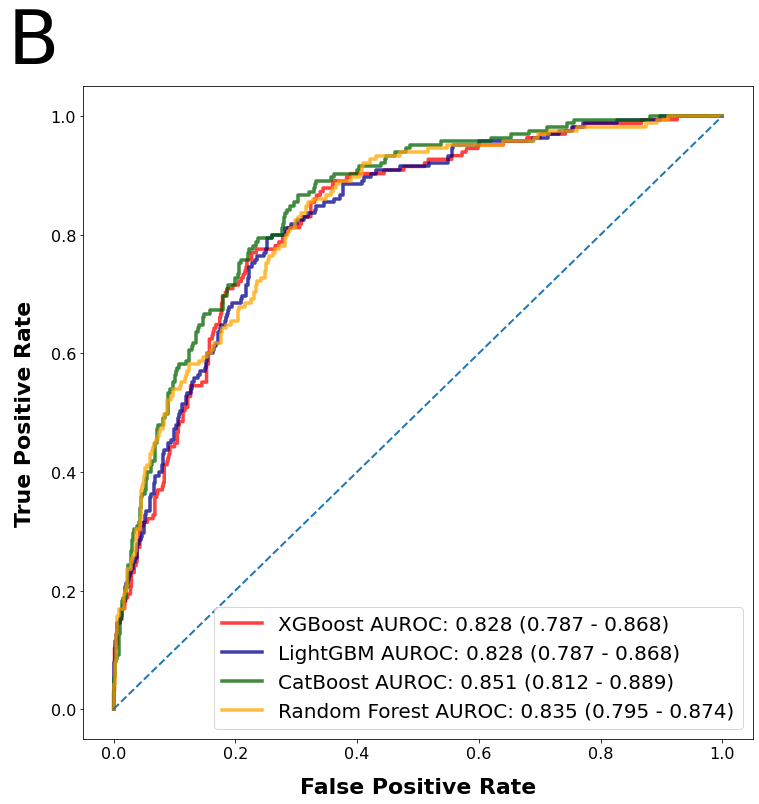

In [48]:
#Plot ROC curve.

f = pyplot.figure()
f.set_figwidth(12)
f.set_figheight(12)

xgb_fpr, xgb_tpr, _ = roc_curve(y_test, probs_xgb)
xgb_label = 'XGBoost AUROC: ' + xgb_auroc
pyplot.plot(xgb_fpr, xgb_tpr, label = xgb_label, color = 'red', linewidth = 3.5, alpha = 0.75)

lgb_fpr, lgb_tpr, _ = roc_curve(y_test, probs_lgb)
lgb_label = 'LightGBM AUROC: ' + lgb_auroc
pyplot.plot(lgb_fpr, lgb_tpr, label = lgb_label, color='darkblue', linewidth = 3.5, alpha = 0.75)

cb_fpr, cb_tpr, _ = roc_curve(y_test, probs_cb)
cb_label = 'CatBoost AUROC: ' + cb_auroc
pyplot.plot(cb_fpr, cb_tpr, label = cb_label, color = 'darkgreen', linewidth = 3.5, alpha = 0.75)

rf_fpr, rf_tpr, _ = roc_curve(y_test, probs_rf)
rf_label = 'Random Forest AUROC: ' + rf_auroc
pyplot.plot(rf_fpr, rf_tpr, label = rf_label, color = 'orange', linewidth = 3.5, alpha = 0.75)

pyplot.plot([0, 1], [0, 1], linestyle = '--', linewidth=2)

pyplot.title('B', x = -0.075, y = 1.005, fontsize = 75, pad = 20)
pyplot.xlabel('False Positive Rate', fontsize = 22, fontweight = 'heavy', labelpad = 16)
pyplot.ylabel('True Positive Rate', fontsize = 22, fontweight = 'heavy', labelpad = 16)
pyplot.tick_params(axis="y",direction="out", labelsize = 16)
pyplot.tick_params(axis="x",direction="out", labelsize = 16)

leg = pyplot.legend(loc = 'lower right', fontsize = 20)

pyplot.savefig('/content/drive/MyDrive/NTDB-Epidural/discharge_roc.png', dpi=300)
pyplot.show()

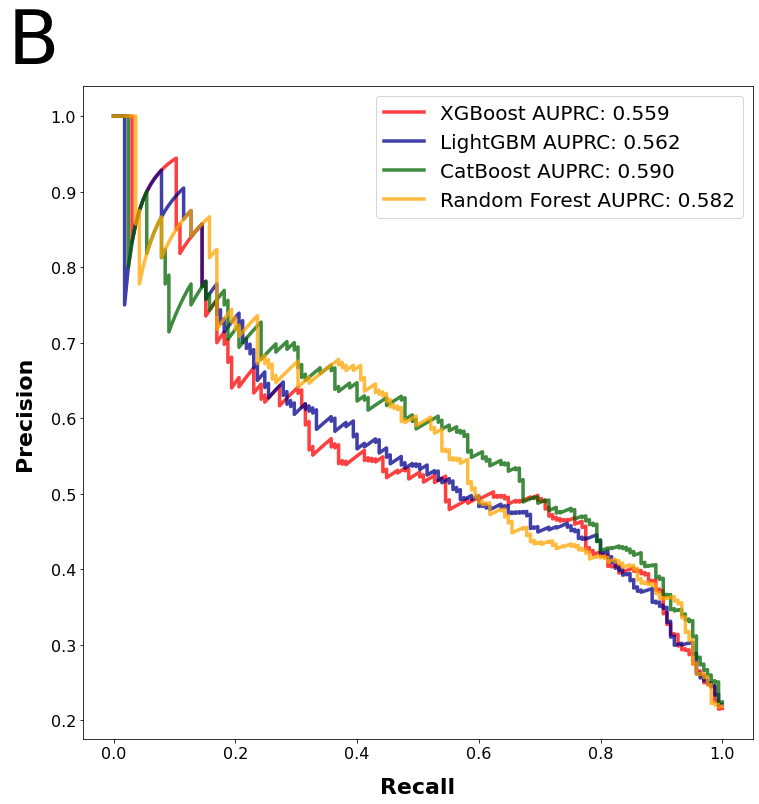

In [49]:
#Plot PR curve.

f = pyplot.figure()
f.set_figwidth(12)
f.set_figheight(12)

pyplot.plot(xgb_recall, xgb_precision, label='XGBoost AUPRC: {:.3f}'.format(xgb_auprc), color = 'red', linewidth = 3.5, alpha = 0.75)
pyplot.plot(lgb_recall, lgb_precision, label='LightGBM AUPRC: {:.3f}'.format(lgb_auprc), color = 'darkblue', linewidth = 3.5, alpha = 0.75)
pyplot.plot(cb_recall, cb_precision, label='CatBoost AUPRC: {:.3f}'.format(cb_auprc), color = 'darkgreen', linewidth = 3.5, alpha = 0.75)
pyplot.plot(rf_recall, rf_precision, label='Random Forest AUPRC: {:.3f}'.format(rf_auprc), color = 'orange', linewidth = 3.5, alpha = 0.75)


pyplot.title('B', x = -0.075, y = 1.005, fontsize = 75, pad = 20)
pyplot.xlabel('Recall', fontsize = 22, fontweight = 'heavy', labelpad = 16)
pyplot.ylabel('Precision', fontsize = 22, fontweight = 'heavy', labelpad = 16)
pyplot.tick_params(axis="y",direction="out", labelsize = 16)
pyplot.tick_params(axis="x",direction="out", labelsize = 16)

leg = pyplot.legend(loc = 'upper right', fontsize = 20)

pyplot.savefig('/content/drive/MyDrive/NTDB-Epidural/discharge_prc.png', dpi=300)
pyplot.show()

# Results Summary

In [50]:
results = {'XGBoost':xgb_results, 'LightGBM':lgb_results, 'CatBoost':cb_results, 'Random Forest':rf_results}

results = pd.DataFrame(results, columns = ['XGBoost', 'LightGBM', 'CatBoost', 'Random Forest'])

results

,XGBoost,LightGBM,CatBoost,Random Forest
0,0.721,0.685,0.564,0.612
1,0.472,0.463,0.585,0.488
2,0.571,0.553,0.574,0.543
3,0.78,0.775,0.83,0.791
4,0.449,0.424,0.468,0.414
5,0.828 (0.787 - 0.868),0.828 (0.787 - 0.868),0.851 (0.812 - 0.889),0.835 (0.795 - 0.874)
6,0.559,0.562,0.59,0.582


In [51]:
results = pd.DataFrame({'XGBoost':xgb_results, 'LightGBM':lgb_results, 'CatBoost':cb_results, 'Random Forest':rf_results})

results = results.T

results.columns = ['Precision', 'Recall', 'F1', 'Accuracy', 'MCC', 'AUROC (95% CI)', 'AUPRC']

results.to_csv('/content/drive/MyDrive/NTDB-Epidural/discharge_results.csv')

results

,Precision,Recall,F1,Accuracy,MCC,AUROC (95% CI),AUPRC
XGBoost,0.721,0.472,0.571,0.78,0.449,0.828 (0.787 - 0.868),0.559
LightGBM,0.685,0.463,0.553,0.775,0.424,0.828 (0.787 - 0.868),0.562
CatBoost,0.564,0.585,0.574,0.83,0.468,0.851 (0.812 - 0.889),0.59
Random Forest,0.612,0.488,0.543,0.791,0.414,0.835 (0.795 - 0.874),0.582


# SHAP Plots

In [52]:
import textwrap
def wrap_labels(ax, width, break_long_words=False):
    labels = []
    for label in ax.get_yticklabels():
        text = label.get_text()
        labels.append(textwrap.fill(text, width=width, 
                                    break_long_words=break_long_words))
    ax.set_yticklabels(labels, rotation=0)

In [53]:
#Calculate SHAP values for XGBoost.

xgb_explainer = shap.Explainer(xgb.predict, x_test)
xgb_shap_values = xgb_explainer(x_test)

Permutation explainer: 814it [01:45,  7.26it/s]


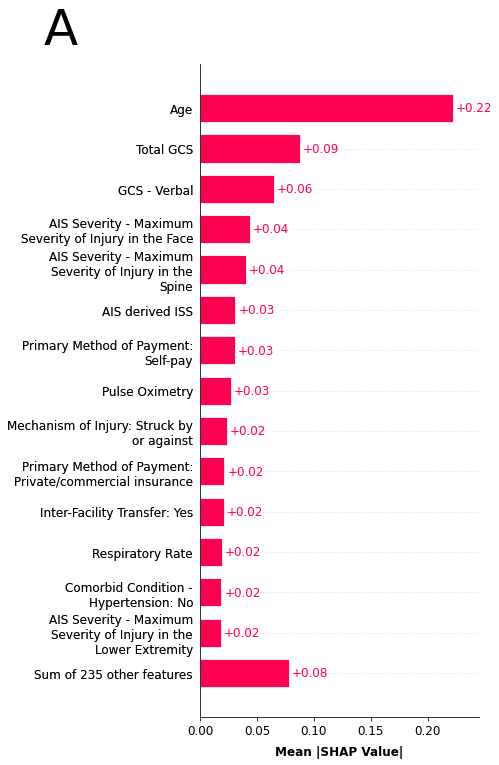

In [54]:
#Plot SHAP bar plot for XGBoost.

shap.plots.bar(xgb_shap_values, max_display = 15, show=False)

fig = pyplot.gcf()
ax = pyplot.gca()
fig.set_figheight(12)
fig.set_figwidth(5)

pyplot.title('A', x = -0.5, y = 1, fontsize = 50, pad = 20)
pyplot.xlabel("Mean |SHAP Value|", fontsize =12, fontweight = 'heavy', labelpad = 8)
pyplot.tick_params(axis="y",direction="out", labelsize = 12)
pyplot.tick_params(axis="x",direction="out", labelsize = 12)

wrap_labels(ax, 30)
ax.figure

pyplot.savefig('/content/drive/MyDrive/NTDB-Epidural/discharge_shap_xgb.png', dpi=300, bbox_inches='tight')

In [55]:
#Calculate SHAP values for LightGBM.

lgb_explainer = shap.Explainer(lgb.predict, x_test)
lgb_shap_values = lgb_explainer(x_test)

Permutation explainer: 814it [01:59,  6.22it/s]


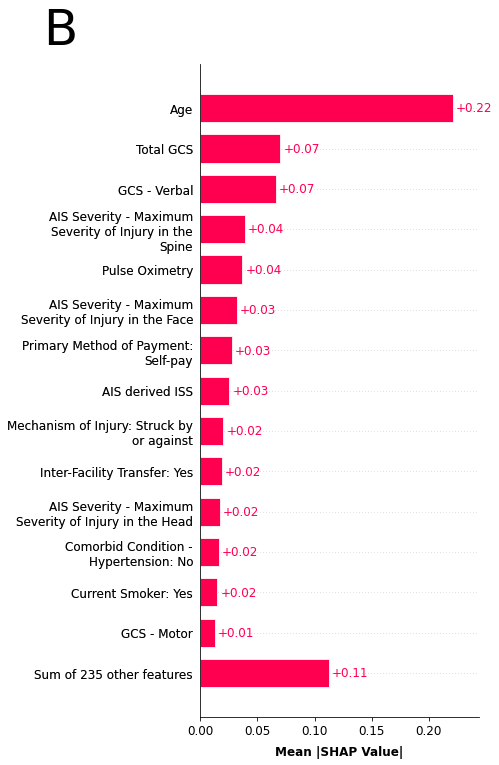

In [56]:
#Plot SHAP bar plot for LightGBM.

shap.plots.bar(lgb_shap_values, max_display = 15, show=False)

fig = pyplot.gcf()
ax = pyplot.gca()
fig.set_figheight(12)
fig.set_figwidth(5)

pyplot.title('B', x = -0.5, y = 1, fontsize = 50, pad = 20)
pyplot.xlabel("Mean |SHAP Value|", fontsize =12, fontweight = 'heavy', labelpad = 8)
pyplot.tick_params(axis="y",direction="out", labelsize = 12)
pyplot.tick_params(axis="x",direction="out", labelsize = 12)

wrap_labels(ax, 30)
ax.figure

pyplot.savefig('/content/drive/MyDrive/NTDB-Epidural/discharge_shap_lgb.png', dpi=300, bbox_inches='tight')

In [57]:
#Calculate SHAP values for CatBoost.

cb_explainer = shap.Explainer(cb.predict, x_test)
cb_shap_values = cb_explainer(x_test)

Permutation explainer: 814it [02:31,  5.03it/s]


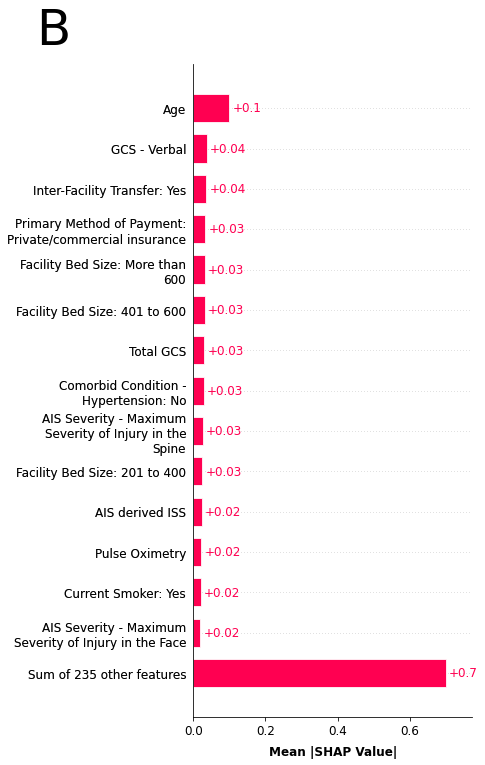

In [58]:
#Plot SHAP bar plot for CatBoost.

shap.plots.bar(cb_shap_values, max_display = 15, show=False)

fig = pyplot.gcf()
ax = pyplot.gca()
fig.set_figheight(12)
fig.set_figwidth(5)

pyplot.title('B', x = -0.5, y = 1, fontsize = 50, pad = 20)
pyplot.xlabel("Mean |SHAP Value|", fontsize =12, fontweight = 'heavy', labelpad = 8)
pyplot.tick_params(axis="y",direction="out", labelsize = 12)
pyplot.tick_params(axis="x",direction="out", labelsize = 12)

wrap_labels(ax, 30)
ax.figure

pyplot.savefig('/content/drive/MyDrive/NTDB-Epidural/discharge_shap_cb.png', dpi=300, bbox_inches='tight')

In [59]:
#Calculate SHAP values for Random Forest.

rf_explainer = shap.Explainer(rf.predict, x_test)
rf_shap_values = rf_explainer(x_test)

Permutation explainer: 814it [42:42,  3.16s/it]


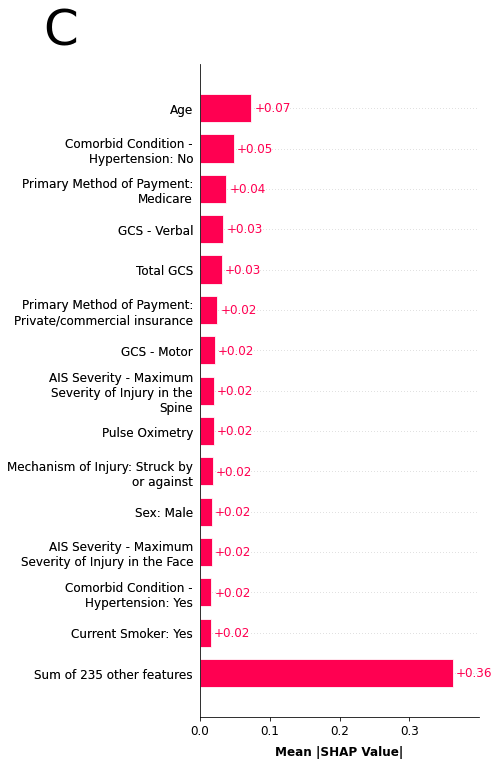

In [60]:
#Plot SHAP bar plot for Random Forest.

shap.plots.bar(rf_shap_values, max_display = 15, show=False)

fig = pyplot.gcf()
ax = pyplot.gca()
fig.set_figheight(12)
fig.set_figwidth(5)

pyplot.title('C', x = -0.5, y = 1, fontsize = 50, pad = 20)
pyplot.xlabel("Mean |SHAP Value|", fontsize =12, fontweight = 'heavy', labelpad = 8)
pyplot.tick_params(axis="y",direction="out", labelsize = 12)
pyplot.tick_params(axis="x",direction="out", labelsize = 12)

wrap_labels(ax, 30)
ax.figure

pyplot.savefig('/content/drive/MyDrive/NTDB-Epidural/discharge_shap_rf.png', dpi=300, bbox_inches='tight')